<a href="https://colab.research.google.com/github/ahlusar1989/google-ml-tf-sketch-work/blob/master/Clustering_Supervised_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
#@title
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Supervised Similarity Measure
We'll cluster chocolates in the [Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings) dataset using k-means with a supervised similarity measure. The dataset has ratings
of chocolate bars along with their cocoa percentage, bean type, bean origin,
maker name, and maker country. You will:

* Load and clean the data.
* Process the data.
* Generate embeddings by training a DNN.
* Cluster the chocolates using k-means.
* Check the clustering result using quality metrics.



# 1. Load and clean data
Run the section below to load and clean the dataset. You do not need to understand the code. The code displays data for the first few chocolates.

In [1]:
#@title Run to load and clean the dataset
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
from os.path import join
from matplotlib import pyplot as plt

import tensorflow as tf

# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

# choc_data.dtypes

# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
# Confirm with choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


# 2. Process Data
Because you're using a DNN, you do not need to manually process the data. The DNN transforms the data for us. However, if possible, you should remove features that could distort the similarity calculation. Here, the features `review_date` and `reference_number` are not correlated with similarity. That is, chocolates that are reviewed closer together in time are not more or less similar than chocolates reviewed further apart. Remove these two features by running the following code.

In [2]:
choc_data.drop(columns=['review_date','reference_number'],inplace=True)
choc_data.head()

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,70.00,France,3.50,Blend,Peru


# 3. Generate Embeddings from DNN

We're ready to generate embeddings by training the DNN on the feature data. This section draws on concepts discussed on the page [Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity).

Run the section below to set up functions to train the DNN that generates embeddings. You do not need to understand the code.

In [0]:
#@title Functions to Build and Train a Similarity DNN Model

class SimilarityModel(object):
  """Class to build, train, and inspect a Similarity Model.

  This class builds a deep neural network that maps a dataset of entities
  with heterogenous features to an embedding space.
  Given a dataset as a pandas dataframe, determine the model by specifying
  the set of features used as input and as labels to the DNN, and the
  size of each hidden layer. The data is mapped to the embedding space
  in the last hidden layer.
  
  To build an auto-encoder, make the set of output features identical to the set
  of input features. Alternatively, build a predictor by using a single feature
  as the label. When using a single feature as a label, ensure
  this feature is removed from the input, or add at least
  one hidden layer of a sufficiently low dimension such that the model cannot
  trivially learn the label.
  Caveat: The total loss being minimized is a simple sum of losses for each
    output label (plus the regularization). If the output feature set combines
    sparse and dense features, the total loss is a sum of cross-entropy soft-max
    losses with root mean squared error losses, potentially in different scales,
    which could emphasis some output labels more than others.
  """

  def __init__(self,
               dataframe,
               input_feature_names,
               output_feature_names,
               dense_feature_names,
               sparse_input_feature_embedding_dims,
               hidden_dims=[32],
               l2_regularization=0.0,
               use_bias=True,
               batch_size=100,
               inspect=False):
    """Build a similarity model.

    Args:
      dataframe: the pandas dataframe used to train and validate the model.
      input_feature_names: list of strings, names of input feature columns.
      output_feature_names: list of strings, names of output feature columns.
      dense_feature_names: list of strings, names of feature columns that are
        treated as dense. All other feature columns are treated as sparse.
      sparse_input_feature_embedding_dims: dictionary that maps feature names to
        ints, expressing the embedding dimension of each input feature. Any
        sparse feature in input_feature_names must be in this dictionary.
      hidden_dims: list of ints, dimensions of each hidden layer. These hidden
        layers are not counting the first layer which is a concatenation of the
        input embeddings and the dense input features. Hence, this list can be
        empty, in which case the outputs of the network are directly connected
        to the input embeddings and/or dense inputs.
      use_bias: bool, if true, add a bias term to each hidden layer.
      batch_size: int, batch size.
      inspect: bool, if true, add each tensor of the model to the list of
        tensors that are inspected.
    """
    used_feature_names = tuple(
        set(input_feature_names).union(output_feature_names))
    sparse_feature_names = tuple(
        set(used_feature_names).difference(dense_feature_names))
    # Dictionary mapping each sparse feature column to its vocabulary.
    ### sparse_feature_vocabs = { 'maker': [u'A. Morin', u'AMMA', ...], ... }
    sparse_feature_vocabs = {
        sfn: sorted(list(set(choc_data[sfn].values)))
        for sfn in sparse_feature_names
    }

    # Sparse output features are mapped to ids via tf.feature_to_id, hence
    # we need key-id pairs for these vocabularies.
    sparse_output_feature_names = (
        tuple(set(sparse_feature_names).intersection(output_feature_names)))
    keys_and_values = {}
    for fn in sparse_output_feature_names:
      keys = tf.constant(
          sparse_feature_vocabs[fn],
          dtype=tf.string,
          name='{}_vocab_keys'.format(fn))
      values = tf.range(
          len(sparse_feature_vocabs[fn]),
          dtype=tf.int64,
          name='{}_vocab_values'.format(fn))
      keys_and_values[fn] = (keys, values)

    # Class instance data members.
    self._session = None
    self._loss = None
    self._metrics = {}
    self._embeddings = None
    self._vars_to_inspect = {}

    def split_dataframe(df, holdout_fraction=0.1):
      """Splits a pandas dataframe into training and test sets.

      Args:
        df: the source pandas dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.

      Returns:
        A pair of non-overlapping pandas dataframe for training and holdout.
      """
      test = df.sample(frac=holdout_fraction, replace=False)
      train = df[~df.index.isin(test.index)]
      return train, test

    train_dataframe, test_dataframe = split_dataframe(dataframe)

    def make_batch(dataframe, batch_size):
      """Creates a batch of examples.

      Args:
        dataframe: a panda dataframe with rows being examples and with
          columns being feature columns.
        batch_size: the batch size.

      Returns:
        A dictionary of tensors, keyed by their feature names.
        Each tensor is of shape [batch_size]. Tensors for sparse features are of
        strings, while tensors for dense features are of floats.
      """
      used_features = {ufn: dataframe[ufn] for ufn in used_feature_names}
      batch = (
          tf.data.Dataset.from_tensor_slices(used_features).shuffle(1000)
          .repeat().batch(batch_size).make_one_shot_iterator().get_next())
      if inspect:
        for k, v in batch.iteritems():
          self._vars_to_inspect['input_%s' % k] = v
      return batch

    def generate_feature_columns(feature_names):
      """Creates the list of used feature columns.

      Args:
        feature_names: an iterable of strings with the names of the features for
          which feature columns are generated.

      Returns:
        A dictionary, keyed by feature names, of _DenseColumn and
        _NumericColumn.
      """
      used_sparse_feature_names = (
          tuple(set(sparse_feature_names).intersection(feature_names)))
      used_dense_feature_names = (
          tuple(set(dense_feature_names).intersection(feature_names)))
      f_columns = {}
      for sfn in used_sparse_feature_names:
        sf_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=sfn,
            vocabulary_list=sparse_feature_vocabs[sfn],
            num_oov_buckets=0)
        f_columns[sfn] = tf.feature_column.embedding_column(
            categorical_column=sf_column,
            dimension=sparse_input_feature_embedding_dims[sfn],
            combiner='mean',
            initializer=tf.truncated_normal_initializer(stddev=.1))
      for dfn in used_dense_feature_names:
        f_columns[dfn] = tf.feature_column.numeric_column(dfn)
      return f_columns

    def create_tower(features, columns):
      """Creates the tower mapping features to embeddings.

      Args:
        features: a dictionary of tensors of shape [batch_size], keyed by
          feature name. Sparse features are associated to tensors of strings,
          while dense features are associated to tensors of floats.
        columns: a dictionary, keyed by feature names, of _DenseColumn and
          _NumericColumn.

      Returns:
        A pair of elements: hidden_layer and output_layer.
          hidden_layer is a tensor of shape [batch_size, hidden_dims[-1]].
          output_layer is a dictionary keyed by the output feature names, of
            dictionaries {'labels': labels, 'logits': logits}.
            Dense output features have both labels and logits as float tensors 
            of shape [batch_size, 1]. Sparse output features have labels as
            string tensors of shape [batch_size, 1] and logits as float tensors
            of shape [batch_size, len(sparse_feature_vocab)].
      """
      # TODO: sanity check the arguments.
      # Input features.
      input_columns = [columns[fn] for fn in input_feature_names]
      hidden_layer = tf.feature_column.input_layer(features, input_columns)
      dense_input_feature_names = (
          tuple(set(dense_feature_names).intersection(input_feature_names)))
      input_dim = (
          sum(sparse_input_feature_embedding_dims.values()) +
          len(dense_input_feature_names))
      for layer_idx, layer_output_dim in enumerate(hidden_dims):
        w = tf.get_variable(
            'hidden%d_w_' % layer_idx,
            shape=[input_dim, layer_output_dim],
            initializer=tf.truncated_normal_initializer(
                stddev=1.0 / np.sqrt(layer_output_dim)))
        if inspect:
          self._vars_to_inspect['hidden%d_w_' % layer_idx] = w
        hidden_layer = tf.matmul(hidden_layer, w)  # / 10.)
        if inspect:
          self._vars_to_inspect['hidden_layer_%d' % layer_idx] = hidden_layer
        input_dim = layer_output_dim
      # Output features.
      output_layer = {}
      for ofn in output_feature_names:
        if ofn in sparse_feature_names:
          feature_dim = len(sparse_feature_vocabs[ofn])
        else:
          feature_dim = 1
        w = tf.get_variable(
            'output_w_%s' % ofn,
            shape=[input_dim, feature_dim],
            initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                        np.sqrt(feature_dim)))
        if inspect:
          self._vars_to_inspect['output_w_%s' % ofn] = w
        if use_bias:
          bias = tf.get_variable(
              'output_bias_%s' % ofn,
              shape=[1, feature_dim],
              initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                          np.sqrt(feature_dim)))
          if inspect:
            self._vars_to_inspect['output_bias_%s' % ofn] = bias
        else:
          bias = tf.constant(0.0, shape=[1, feature_dim])
        output_layer[ofn] = {
            'labels':
                features[ofn],
            'logits':
                tf.add(tf.matmul(hidden_layer, w), bias)  # w / 10.), bias)
        }
        if inspect:
          self._vars_to_inspect['output_labels_%s' %
                                ofn] = output_layer[ofn]['labels']
          self._vars_to_inspect['output_logits_%s' %
                                ofn] = output_layer[ofn]['logits']
      return hidden_layer, output_layer

    def similarity_loss(top_embeddings, output_layer):
      """Build the loss to be optimized.

      Args:
        top_embeddings: First element returned by create_tower.
        output_layer: Second element returned by create_tower.

      Returns:
        total_loss: A tensor of shape [1] with the total loss to be optimized.
        losses: A dictionary keyed by output feature names, of tensors of shape
          [1] with the contribution to the loss of each output feature.
      """
      losses = {}
      total_loss = tf.scalar_mul(l2_regularization,
                                 tf.nn.l2_loss(top_embeddings))
      for fn, output in output_layer.iteritems():
        if fn in sparse_feature_names:
          losses[fn] = tf.reduce_mean(
              tf.nn.sparse_softmax_cross_entropy_with_logits(
                  logits=output['logits'],
                  labels=tf.feature_to_id(
                      output['labels'], keys_and_values=keys_and_values[fn])))
        else:
          losses[fn] = tf.sqrt(
              tf.reduce_mean(
                  tf.square(output['logits'] -
                            tf.cast(output['labels'], tf.float32))))
        total_loss += losses[fn]
      return total_loss, losses

    # Body of the constructor.
    input_feature_columns = generate_feature_columns(input_feature_names)
    # Train
    with tf.variable_scope('model', reuse=False):
      train_hidden_layer, train_output_layer = create_tower(
          make_batch(train_dataframe, batch_size), input_feature_columns)
      self._train_loss, train_losses = similarity_loss(train_hidden_layer,
                                                       train_output_layer)
    # Test
    with tf.variable_scope('model', reuse=True):
      test_hidden_layer, test_output_layer = create_tower(
          make_batch(test_dataframe, batch_size), input_feature_columns)
      test_loss, test_losses = similarity_loss(test_hidden_layer,
                                               test_output_layer)
    # Whole dataframe to get final embeddings
    with tf.variable_scope('model', reuse=True):
      self._hidden_layer, _ = create_tower(
          make_batch(dataframe, dataframe.shape[0]), input_feature_columns)
    # Metrics is a dictionary of dictionaries of dictionaries.
    # The 3 levels are used as plots, line colors, and line styles respectively.
    self._metrics = {
        'total': {
            'train': {'loss': self._train_loss},
            'test': {'loss': test_loss}
        },
        'feature': {
            'train': {'%s loss' % k: v for k, v in train_losses.iteritems()},
            'test': {'%s loss' % k: v for k, v in test_losses.iteritems()}
        }
    }

  def train(self,
            num_iterations=30,
            learning_rate=1.0,
            plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.

    Args:
      num_iterations: int, the number of iterations to run.
      learning_rate: float, the optimizer learning rate.
      plot_results: bool, whether to plot the results at the end of training.
      optimizer: tf.train.Optimizer, the optimizer to be used for training.
    """
    with self._train_loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._train_loss)
      opt_init_op = tf.variables_initializer(opt.variables())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.local_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      self._session.run(opt_init_op)
      if plot_results:  
        iterations = []
        metrics_vals = {k0: {k1: {k2: []
                                  for k2 in v1}
                             for k1, v1 in v0.iteritems()}
                        for k0, v0 in self._metrics.iteritems()}

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, self._metrics))

        # Printing the 1 liner with losses.
        if (i % 10 == 0) or i == num_iterations:
          print('\riteration%6d,   ' % i + ',   '.join(
              ['%s %s %s: %7.3f' % (k0, k1, k2, v2)
               for k0, v0 in results.iteritems()
               for k1, v1 in v0.iteritems()
               for k2, v2 in v1.iteritems()])
                , end=" "
               )
          if plot_results:
            iterations.append(i)
            for k0, v0 in results.iteritems():
              for k1, v1 in v0.iteritems():
                for k2, v2 in v1.iteritems():
                  metrics_vals[k0][k1][k2].append(results[k0][k1][k2])

      # Feedforward the entire dataframe to get all the embeddings.
      self._embeddings = self._session.run(self._hidden_layer)

      # Plot the losses and embeddings.
      if plot_results:
        num_subplots = len(metrics_vals) + 1
        colors = 10 * ('red', 'blue', 'black', 'green')
        styles = 10 * ('-', '--', '-.', ':')
        # Plot the metrics.
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i0, (k0, v0) in enumerate(metrics_vals.iteritems()):
          ax = fig.add_subplot(1, num_subplots, i0+1)
          ax.set_title(k0)
          for i1, (k1, v1) in enumerate(v0.iteritems()):
            for i2, (k2, v2) in enumerate(v1.iteritems()):
              ax.plot(iterations, v2, label='%s %s' % (k1, k2),
                      color=colors[i1], linestyle=styles[i2])
          ax.set_xlim([1, num_iterations])
          ax.set_yscale('log')
          ax.legend()
        # Plot the embeddings (first 3 dimensions).
        ax.legend(loc='upper right')
        ax = fig.add_subplot(1, num_subplots, num_subplots)
        ax.scatter(
            self._embeddings[:, 0], self._embeddings[:, 1],
            alpha=0.5, marker='o')
        ax.set_title('embeddings')


  @property
  def embeddings(self):
    return self._embeddings

The next cell trains the DNN. You can choose either a predictor DNN or an autoencoder DNN by specifying the parameter `output_feature_names` as follows:

* If choosing a predictor DNN, specify one feature, for example, [`rating`].
* If choosing an autoencoder DNN, specify all features as follows: `['maker','maker_location','broad_origin','cocoa_percent','bean_type','rating']`.

You do not need to change the other parameters, but if you're curious:
* `l2_regularization`: Controls the weight for L2 regularization.
* `hidden_dims`: Controls the dimensions of the hidden layers.

Running the next cell generates the following plots:

* '*total*': Total loss across all features.
* '*feature*': Loss for the specified output features.
* '*embeddings*': First two dimensions of the generated embeddings.

------ build model
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs in

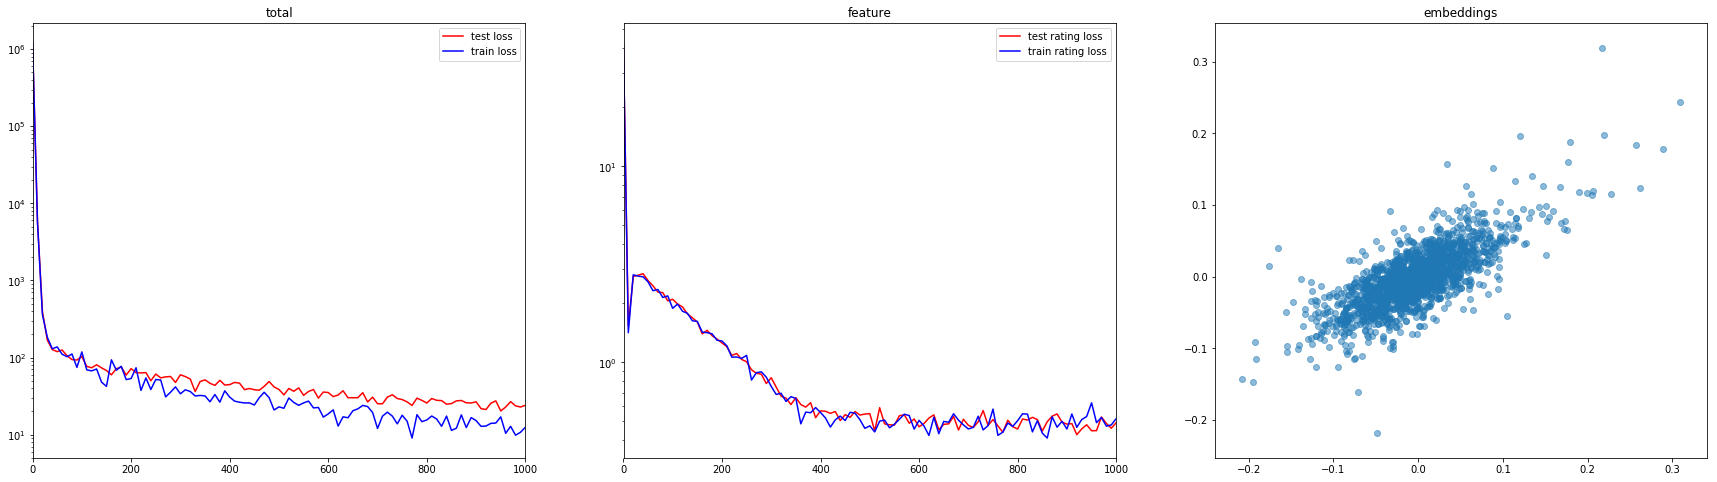

In [6]:
#@title Functions to Build and Train a Similarity DNN Model

class SimilarityModel(object):
  """Class to build, train, and inspect a Similarity Model.

  This class builds a deep neural network that maps a dataset of entities
  with heterogenous features to an embedding space.
  Given a dataset as a pandas dataframe, determine the model by specifying
  the set of features used as input and as labels to the DNN, and the
  size of each hidden layer. The data is mapped to the embedding space
  in the last hidden layer.
  
  To build an auto-encoder, make the set of output features identical to the set
  of input features. Alternatively, build a predictor by using a single feature
  as the label. When using a single feature as a label, ensure
  this feature is removed from the input, or add at least
  one hidden layer of a sufficiently low dimension such that the model cannot
  trivially learn the label.
  Caveat: The total loss being minimized is a simple sum of losses for each
    output label (plus the regularization). If the output feature set combines
    sparse and dense features, the total loss is a sum of cross-entropy soft-max
    losses with root mean squared error losses, potentially in different scales,
    which could emphasis some output labels more than others.
  """

  def __init__(self,
               dataframe,
               input_feature_names,
               output_feature_names,
               dense_feature_names,
               sparse_input_feature_embedding_dims,
               hidden_dims=[32],
               l2_regularization=0.0,
               use_bias=True,
               batch_size=100,
               inspect=False):
    """Build a similarity model.

    Args:
      dataframe: the pandas dataframe used to train and validate the model.
      input_feature_names: list of strings, names of input feature columns.
      output_feature_names: list of strings, names of output feature columns.
      dense_feature_names: list of strings, names of feature columns that are
        treated as dense. All other feature columns are treated as sparse.
      sparse_input_feature_embedding_dims: dictionary that maps feature names to
        ints, expressing the embedding dimension of each input feature. Any
        sparse feature in input_feature_names must be in this dictionary.
      hidden_dims: list of ints, dimensions of each hidden layer. These hidden
        layers are not counting the first layer which is a concatenation of the
        input embeddings and the dense input features. Hence, this list can be
        empty, in which case the outputs of the network are directly connected
        to the input embeddings and/or dense inputs.
      use_bias: bool, if true, add a bias term to each hidden layer.
      batch_size: int, batch size.
      inspect: bool, if true, add each tensor of the model to the list of
        tensors that are inspected.
    """
    used_feature_names = tuple(
        set(input_feature_names).union(output_feature_names))
    sparse_feature_names = tuple(
        set(used_feature_names).difference(dense_feature_names))
    # Dictionary mapping each sparse feature column to its vocabulary.
    ### sparse_feature_vocabs = { 'maker': [u'A. Morin', u'AMMA', ...], ... }
    sparse_feature_vocabs = {
        sfn: sorted(list(set(choc_data[sfn].values)))
        for sfn in sparse_feature_names
    }

    # Sparse output features are mapped to ids via tf.feature_to_id, hence
    # we need key-id pairs for these vocabularies.
    sparse_output_feature_names = (
        tuple(set(sparse_feature_names).intersection(output_feature_names)))
    keys_and_values = {}
    for fn in sparse_output_feature_names:
      keys = tf.constant(
          sparse_feature_vocabs[fn],
          dtype=tf.string,
          name='{}_vocab_keys'.format(fn))
      values = tf.range(
          len(sparse_feature_vocabs[fn]),
          dtype=tf.int64,
          name='{}_vocab_values'.format(fn))
      keys_and_values[fn] = (keys, values)

    # Class instance data members.
    self._session = None
    self._loss = None
    self._metrics = {}
    self._embeddings = None
    self._vars_to_inspect = {}

    def split_dataframe(df, holdout_fraction=0.1):
      """Splits a pandas dataframe into training and test sets.

      Args:
        df: the source pandas dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.

      Returns:
        A pair of non-overlapping pandas dataframe for training and holdout.
      """
      test = df.sample(frac=holdout_fraction, replace=False)
      train = df[~df.index.isin(test.index)]
      return train, test

    train_dataframe, test_dataframe = split_dataframe(dataframe)

    def make_batch(dataframe, batch_size):
      """Creates a batch of examples.

      Args:
        dataframe: a panda dataframe with rows being examples and with
          columns being feature columns.
        batch_size: the batch size.

      Returns:
        A dictionary of tensors, keyed by their feature names.
        Each tensor is of shape [batch_size]. Tensors for sparse features are of
        strings, while tensors for dense features are of floats.
      """
      used_features = {ufn: dataframe[ufn] for ufn in used_feature_names}
      batch = (
          tf.data.Dataset.from_tensor_slices(used_features).shuffle(1000)
          .repeat().batch(batch_size).make_one_shot_iterator().get_next())
      if inspect:
        for k, v in batch.iteritems():
          self._vars_to_inspect['input_%s' % k] = v
      return batch

    def generate_feature_columns(feature_names):
      """Creates the list of used feature columns.

      Args:
        feature_names: an iterable of strings with the names of the features for
          which feature columns are generated.

      Returns:
        A dictionary, keyed by feature names, of _DenseColumn and
        _NumericColumn.
      """
      used_sparse_feature_names = (
          tuple(set(sparse_feature_names).intersection(feature_names)))
      used_dense_feature_names = (
          tuple(set(dense_feature_names).intersection(feature_names)))
      f_columns = {}
      for sfn in used_sparse_feature_names:
        sf_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=sfn,
            vocabulary_list=sparse_feature_vocabs[sfn],
            num_oov_buckets=0)
        f_columns[sfn] = tf.feature_column.embedding_column(
            categorical_column=sf_column,
            dimension=sparse_input_feature_embedding_dims[sfn],
            combiner='mean',
            initializer=tf.truncated_normal_initializer(stddev=.1))
      for dfn in used_dense_feature_names:
        f_columns[dfn] = tf.feature_column.numeric_column(dfn)
      return f_columns

    def create_tower(features, columns):
      """Creates the tower mapping features to embeddings.

      Args:
        features: a dictionary of tensors of shape [batch_size], keyed by
          feature name. Sparse features are associated to tensors of strings,
          while dense features are associated to tensors of floats.
        columns: a dictionary, keyed by feature names, of _DenseColumn and
          _NumericColumn.

      Returns:
        A pair of elements: hidden_layer and output_layer.
          hidden_layer is a tensor of shape [batch_size, hidden_dims[-1]].
          output_layer is a dictionary keyed by the output feature names, of
            dictionaries {'labels': labels, 'logits': logits}.
            Dense output features have both labels and logits as float tensors 
            of shape [batch_size, 1]. Sparse output features have labels as
            string tensors of shape [batch_size, 1] and logits as float tensors
            of shape [batch_size, len(sparse_feature_vocab)].
      """
      # TODO: sanity check the arguments.
      # Input features.
      input_columns = [columns[fn] for fn in input_feature_names]
      hidden_layer = tf.feature_column.input_layer(features, input_columns)
      dense_input_feature_names = (
          tuple(set(dense_feature_names).intersection(input_feature_names)))
      input_dim = (
          sum(sparse_input_feature_embedding_dims.values()) +
          len(dense_input_feature_names))
      for layer_idx, layer_output_dim in enumerate(hidden_dims):
        w = tf.get_variable(
            'hidden%d_w_' % layer_idx,
            shape=[input_dim, layer_output_dim],
            initializer=tf.truncated_normal_initializer(
                stddev=1.0 / np.sqrt(layer_output_dim)))
        if inspect:
          self._vars_to_inspect['hidden%d_w_' % layer_idx] = w
        hidden_layer = tf.matmul(hidden_layer, w)  # / 10.)
        if inspect:
          self._vars_to_inspect['hidden_layer_%d' % layer_idx] = hidden_layer
        input_dim = layer_output_dim
      # Output features.
      output_layer = {}
      for ofn in output_feature_names:
        if ofn in sparse_feature_names:
          feature_dim = len(sparse_feature_vocabs[ofn])
        else:
          feature_dim = 1
        w = tf.get_variable(
            'output_w_%s' % ofn,
            shape=[input_dim, feature_dim],
            initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                        np.sqrt(feature_dim)))
        if inspect:
          self._vars_to_inspect['output_w_%s' % ofn] = w
        if use_bias:
          bias = tf.get_variable(
              'output_bias_%s' % ofn,
              shape=[1, feature_dim],
              initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                          np.sqrt(feature_dim)))
          if inspect:
            self._vars_to_inspect['output_bias_%s' % ofn] = bias
        else:
          bias = tf.constant(0.0, shape=[1, feature_dim])
        output_layer[ofn] = {
            'labels':
                features[ofn],
            'logits':
                tf.add(tf.matmul(hidden_layer, w), bias)  # w / 10.), bias)
        }
        if inspect:
          self._vars_to_inspect['output_labels_%s' %
                                ofn] = output_layer[ofn]['labels']
          self._vars_to_inspect['output_logits_%s' %
                                ofn] = output_layer[ofn]['logits']
      return hidden_layer, output_layer

    def similarity_loss(top_embeddings, output_layer):
      """Build the loss to be optimized.

      Args:
        top_embeddings: First element returned by create_tower.
        output_layer: Second element returned by create_tower.

      Returns:
        total_loss: A tensor of shape [1] with the total loss to be optimized.
        losses: A dictionary keyed by output feature names, of tensors of shape
          [1] with the contribution to the loss of each output feature.
      """
      losses = {}
      total_loss = tf.scalar_mul(l2_regularization,
                                 tf.nn.l2_loss(top_embeddings))
      for fn, output in output_layer.iteritems():
        if fn in sparse_feature_names:
          losses[fn] = tf.reduce_mean(
              tf.nn.sparse_softmax_cross_entropy_with_logits(
                  logits=output['logits'],
                  labels=tf.feature_to_id(
                      output['labels'], keys_and_values=keys_and_values[fn])))
        else:
          losses[fn] = tf.sqrt(
              tf.reduce_mean(
                  tf.square(output['logits'] -
                            tf.cast(output['labels'], tf.float32))))
        total_loss += losses[fn]
      return total_loss, losses

    # Body of the constructor.
    input_feature_columns = generate_feature_columns(input_feature_names)
    # Train
    with tf.variable_scope('model', reuse=False):
      train_hidden_layer, train_output_layer = create_tower(
          make_batch(train_dataframe, batch_size), input_feature_columns)
      self._train_loss, train_losses = similarity_loss(train_hidden_layer,
                                                       train_output_layer)
    # Test
    with tf.variable_scope('model', reuse=True):
      test_hidden_layer, test_output_layer = create_tower(
          make_batch(test_dataframe, batch_size), input_feature_columns)
      test_loss, test_losses = similarity_loss(test_hidden_layer,
                                               test_output_layer)
    # Whole dataframe to get final embeddings
    with tf.variable_scope('model', reuse=True):
      self._hidden_layer, _ = create_tower(
          make_batch(dataframe, dataframe.shape[0]), input_feature_columns)
    # Metrics is a dictionary of dictionaries of dictionaries.
    # The 3 levels are used as plots, line colors, and line styles respectively.
    self._metrics = {
        'total': {
            'train': {'loss': self._train_loss},
            'test': {'loss': test_loss}
        },
        'feature': {
            'train': {'%s loss' % k: v for k, v in train_losses.iteritems()},
            'test': {'%s loss' % k: v for k, v in test_losses.iteritems()}
        }
    }

  def train(self,
            num_iterations=30,
            learning_rate=1.0,
            plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.

    Args:
      num_iterations: int, the number of iterations to run.
      learning_rate: float, the optimizer learning rate.
      plot_results: bool, whether to plot the results at the end of training.
      optimizer: tf.train.Optimizer, the optimizer to be used for training.
    """
    with self._train_loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._train_loss)
      opt_init_op = tf.variables_initializer(opt.variables())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.local_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      self._session.run(opt_init_op)
      if plot_results:  
        iterations = []
        metrics_vals = {k0: {k1: {k2: []
                                  for k2 in v1}
                             for k1, v1 in v0.iteritems()}
                        for k0, v0 in self._metrics.iteritems()}

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, self._metrics))

        # Printing the 1 liner with losses.
        if (i % 10 == 0) or i == num_iterations:
          print('\riteration%6d,   ' % i + ',   '.join(
              ['%s %s %s: %7.3f' % (k0, k1, k2, v2)
               for k0, v0 in results.iteritems()
               for k1, v1 in v0.iteritems()
               for k2, v2 in v1.iteritems()])
                , end=" "
               )
          if plot_results:
            iterations.append(i)
            for k0, v0 in results.iteritems():
              for k1, v1 in v0.iteritems():
                for k2, v2 in v1.iteritems():
                  metrics_vals[k0][k1][k2].append(results[k0][k1][k2])

      # Feedforward the entire dataframe to get all the embeddings.
      self._embeddings = self._session.run(self._hidden_layer)

      # Plot the losses and embeddings.
      if plot_results:
        num_subplots = len(metrics_vals) + 1
        colors = 10 * ('red', 'blue', 'black', 'green')
        styles = 10 * ('-', '--', '-.', ':')
        # Plot the metrics.
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i0, (k0, v0) in enumerate(metrics_vals.iteritems()):
          ax = fig.add_subplot(1, num_subplots, i0+1)
          ax.set_title(k0)
          for i1, (k1, v1) in enumerate(v0.iteritems()):
            for i2, (k2, v2) in enumerate(v1.iteritems()):
              ax.plot(iterations, v2, label='%s %s' % (k1, k2),
                      color=colors[i1], linestyle=styles[i2])
          ax.set_xlim([1, num_iterations])
          ax.set_yscale('log')
          ax.legend()
        # Plot the embeddings (first 3 dimensions).
        ax.legend(loc='upper right')
        ax = fig.add_subplot(1, num_subplots, num_subplots)
        ax.scatter(
            self._embeddings[:, 0], self._embeddings[:, 1],
            alpha=0.5, marker='o')
        ax.set_title('embeddings')


  @property
  def embeddings(self):
    return self._embeddings



# Define some constants related to this dataset.
sparse_feature_names = ('maker', 'maker_location', 'broad_origin',
                        'specific_origin', 'bean_type')
dense_feature_names = ('reference_number', 'review_date', 'cocoa_percent',
                       'rating')

# Set of features used as input to the similarity model.
input_feature_names = ('maker', 'maker_location', 'broad_origin',
                       'cocoa_percent', 'bean_type','rating', )
# Set of features used as output to the similarity model.
output_feature_names = ['rating']  #@param

# As a rule of thumb, a reasonable choice for the embedding dimension of a
# sparse feature column is the log2 of the cardinality of its vocabulary.
# sparse_input_feature_embedding_dims = { 'maker': 9, 'maker_location': 6, ... }
default_embedding_dims = {
    sfn: int(round(math.log(choc_data[sfn].nunique()) / math.log(2)))
    for sfn in set(sparse_feature_names).intersection(input_feature_names)
}
# Dictionary mapping each sparse input feature to the dimension of its embedding
# space.
sparse_input_feature_embedding_dims = default_embedding_dims  # can be a param

# Weight of the L2 regularization applied to the top embedding layer.
l2_regularization = 10  #@param
# List of dimensions of the hidden layers of the deep neural network.
hidden_dims = [20, 10]  #@param

print('------ build model')
with tf.Graph().as_default():
  similarity_model = SimilarityModel(
      choc_data,
      input_feature_names=input_feature_names,
      output_feature_names=output_feature_names,
      dense_feature_names=dense_feature_names,
      sparse_input_feature_embedding_dims=sparse_input_feature_embedding_dims,
      hidden_dims=hidden_dims,
      l2_regularization=l2_regularization,
      batch_size=100,
      use_bias=True,
      inspect=True)

print('------ train model')
similarity_model.train(
    num_iterations=1000,
    learning_rate=0.1,
    optimizer=tf.train.AdagradOptimizer)
print('\n')


# 4. Cluster Chocolate Dataset
We're ready to cluster the chocolates! Run the code to set up the k-means clustering functions. You do not need to understand the code.

**Note**: If you're following the Clustering self study, then before running the rest of this Colab, read the sections on [k-means](https://developers.google.com/machine-learning/clustering/algorithm/run-algorithm) and [quality metrics](https://developers.google.com/machine-learning/clustering/interpret).

In [0]:
#@title Run cell to set up functions
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df,axis=1))
  pointNorms = np.reshape(pointNorms,[numPoints,1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids,axis=1))
  centroidNorms = np.reshape(centroidNorms,(1,numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0*np.dot(df,np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities/10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df,k,feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0,limit-1,k)
  centroids = df.loc[centroids_key,feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True,inplace=True)
  return centroids

def pt2centroid(df,centroids,feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:,feature_cols], centroids.loc[:,feature_cols])
  df.loc[:,'centroid'] = np.argmin(dist,axis=1) # closest centroid
  df.loc[:,'pt2centroid'] = np.min(dist,axis=1) # minimum distance
  return df

def recomputeCentroids(df,centroids,feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen, feature_cols] # all points for centroid
    if not(dfSubset.empty): # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset)/len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids

def kmeans(df,k,feature_cols,verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0                      # ensure kmeans doesn't run for ever
  centroids = initCentroids(df,k,feature_cols)
  while not(flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df,centroids,feature_cols)
    centroids = recomputeCentroids(df,centroids,feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print("Total distance:" + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df,centroids]

Run the following cell to cluster the chocolate dataset, where `k` is the number of clusters. You'll experiment with different values of `k` later. For now, use `k = 160`.

On every iteration of k-means, the output shows how the sum of distances from all examples to their centroids reduces, such that k-means always converges. The following table shows the data for the first few chocolates. On the extreme right of the table, check the assigned centroid for each example in the `centroid` column and the distance from the example to its centroid in the `pt2centroid` column.



In [8]:
k = 160 #@param

# Extract embeddings into a dataframe
choc_embed = similarity_model.embeddings
choc_embed = pd.DataFrame(choc_embed)

feature_cols = choc_embed.columns.values # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_embed['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_embed['pt2centroid'] = 2
[choc_embed,centroids] = kmeans(choc_embed,k,feature_cols,1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:")
choc_embed.head()

Total distance:28.470139
Total distance:25.663094
Total distance:24.80089
Total distance:24.490208
Total distance:24.327051
Total distance:24.199863
Total distance:24.11817
Total distance:24.055895
Total distance:24.016941
Total distance:23.992474
Total distance:23.985977
Total distance:23.98175
k-means converged for 160 clusters after 12 iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,0,1,2,3,4,5,6,7,8,9,centroid,pt2centroid
0,-0.14,-0.00,-0.16,-0.14,0.02,-0.06,0.06,-0.06,-0.00,-0.09,104,0.03
1,-0.03,0.00,0.00,-0.04,0.00,-0.03,0.01,0.01,-0.01,-0.03,112,0.01
2,-0.06,-0.01,0.01,-0.04,-0.01,-0.03,-0.02,0.01,-0.02,-0.03,93,0.01
3,-0.07,-0.03,-0.05,-0.11,-0.02,-0.04,0.03,0.00,0.01,-0.06,84,0.01
4,-0.01,-0.01,-0.00,-0.01,0.01,-0.00,0.01,-0.01,-0.01,-0.01,66,0.01


## Inspect Clustering Result

Inspect the chocolates in different clusters by changing the parameter `clusterNumber`
in the next cell and running the cell. Consider these questions as you inspect the clusters:

* Are the clusters meaningful?
* Is the clustering result better with a manual similarity measure (see your previous Colab) or a supervised similarity measure?
* Does changing the number of clusters make the clusters more or less meaningful?

For context, on the page [Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity), read the table "*Comparison of Manual and Supervised Measures*". Then click the next cell for the discussion.

In [9]:
clusterNumber = 20 #@param
choc_data.loc[choc_embed['centroid']==clusterNumber,:]

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
266,Brazen,Ambolikapkly P,60.00,U.S.A.,3.25,Blend,Madagascar
330,C-Amaro,Ecuador,100.00,Italy,3.50,Blend,Ecuador
342,Caoni (Tulicorp),Manabi,55.00,Ecuador,3.00,Forastero (Arriba),Ecuador
379,Chchukululu (Tulicorp),Los Rios,75.00,Ecuador,3.00,Forastero (Arriba),Ecuador
416,Chocovic,Kendari,60.00,Spain,3.25,Blend,Kendari
617,Emerald Estate,Emerald Estate,60.00,St. Lucia,2.75,Blend,St Lucia
621,ENNA,"Wampusirpi,batch 007",75.00,U.S.A.,3.25,Blend,Honduras
748,Guido Castagna,Blend,64.00,Italy,3.25,Blend,"Venezuela,Trinidad,Ecuador"
907,Kto,Elvesia,72.00,U.S.A.,3.25,Blend,Dominican Republic
949,Laia aka Chat-Noir,"Lam Dong,Batch 153",75.00,France,3.75,Trinitario,Vietnam


### Solution: Discussion of clustering results
Click below for the answer.

**Discussion**:

**Q. Are the clusters meaningful?** 

The clusters become more meaningful when you increase the number of clusters above approximately 100. Below ~100 clusters, dissimilar chocolates tend to be grouped together. Specifically, the grouping of numeric features is more meaningful than the categorical features. A possible cause is that the DNN isn't accurately encoding the categorical features because ~1800 examples isn't enough data to encode each of the dozens of values that categorical features have.

**Q. Is the clustering result better with a manual similarity measure or a supervised similarity measure?**

The clusters are more meaningful for the manual similarity measure because you customized the measure to accurately capture similarity between chocolates. Manual design was possible because the dataset was not complex. In comparison, in your supervised similarity measure, you just threw your data into the DNN and relied on the DNN to encode the similarity. The disadvantage is that with such a small dataset, the DNN lacks the data to accurately encode similarity.

**Q. Does changing the number of clusters make the clusters more or less meaningful?**

Increasing the number of clusters makes the clusters more meaningful up to a limit, because dissimilar chocolates can be broken up into distinct clusters.

# 5. Quality Metrics for Clusters
For the clusters, let's calculate the metrics discussed in [Interpret Results](https://developers.google.com/machine-learning/clustering/interpret). Read that course content before starting this code section.

Run the next cell to set up functions.

In [0]:
#@title Run cell to setup functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df["centroid"]) + 1
  k = k.astype(int)
  print("Number of clusters:"+str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df["centroid"]==kk)
  clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k),clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Points in Cluster')
  return clCard

def clusterMagnitude(df):
  k = np.max(df["centroid"]) + 1
  k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df["centroid"]==kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx,"pt2centroid"])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k),clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag

def plotCardVsMag(clCard,clMag):
  plt.figure()
  plt.scatter(clCard,clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')

def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard,clMag)

Calculate the following metrics by running the next cell:

* cardinality of your clusters
* magnitude of your clusters
* cardinality vs magnitude

Observe:
* The plots show that inspecting cluster metrics for many clusters isn't easy. However, the plots provide a general idea of the quality of the clustering. There are a number of outlying clusters.
* The correlation between cluster cardinality and cluster magnitude is lower than it was for a manual similarity measure. The lower correlation shows that some chocolates were harder to cluster, leading to large example-centroid distances.

Experiment by changing these options and checking the result:
* dimensions of DNN's hidden layer
* autoencoder or predictor DNN
* number of clusters

Number of clusters:160


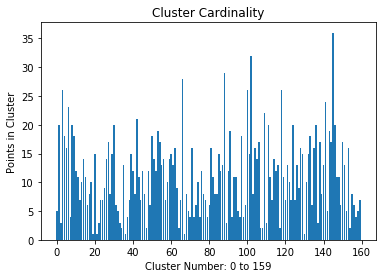

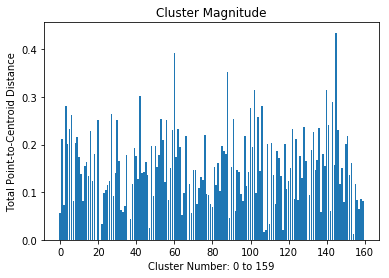

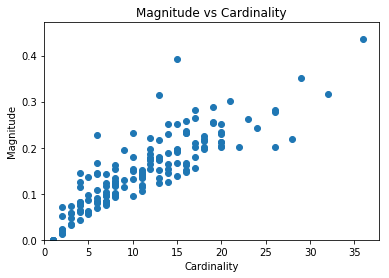

In [12]:

#@title Run cell to set up functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df['centroid']) + 1
  k = k.astype(int)
  print('Number of clusters:' + str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df['centroid'] == kk)
  clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k), clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Points in Cluster')
  return clCard


def clusterMagnitude(df):
  k = np.max(df['centroid']) + 1
  k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df['centroid'] == kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k), clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag


def plotCardVsMag(clCard, clMag):
  plt.figure()
  plt.scatter(clCard, clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard, clMag)


clusterQualityMetrics(choc_embed)

## Find Optimum Number of Clusters

Let's try finding the right number of clusters as you did in the previous programming exercise. For details, read "*Step Three: Optimum Number of Clusters*" on [Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).

Run the code below (it takes a while!). The resulting plot is uneven for low `k`, showing that the k-means has a difficult time clustering the data. As `k` increases past 100, the loss evens out, showing that k-means is effectively grouping the data into clusters.

In [0]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax += 1  # include kmax-th cluster in range
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 200  # @param
kstep = 10  # @param
lossVsClusters(kmin, kmax, kstep, choc_embed)

# Summary

The codelab demonstrates these characteristics of a supervised similarity measure, described on the page [Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity) in the table "*Comparison of Manual and Supervised Measures*":

* **Eliminates redundant information in correlated features**. As discussed in this [section](#scrollTo=MJtuP9w5jJHq), the DNN eliminates redundant information. However, to prove this characteristic, you'd need to train the DNN on adequate data and then compare with the results of a manual similarity measure.
* **Does not provides insight into calculated similarities**. Because you do not know what the embeddings represent, you have no insight into the clustering result.
* **Suitable for large datasets with complex features**. Our dataset was too small to adequately train the DNN, demonstrating that DNNs need large datasets to train. The advantage is that you do not need to understand the input data. Since large datasets are not easy to understand, these two characteristics go hand-in-hand.
* **Not suitable for small datasets**. A small dataset does not have enough information to train the DNN.